In [1]:
# Libraries

import numpy as np
import sys
import math
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
sys.setrecursionlimit(10**9)

In [3]:
# Matrix Grid

def rotate(point, angle, around=(0, 0)):
    # Rotating a point around any other in cartesian coordinate system
    m, n = point
    off_m, off_n = around
    adjusted_m = (m - off_m)
    adjusted_n = (n - off_n)
    cos_angle = math.cos(angle)
    sin_angle = math.sin(angle)
    rot_m = off_m + cos_angle*adjusted_m + sin_angle*adjusted_n
    rot_n = off_n - sin_angle*adjusted_m + cos_angle*adjusted_n
    return rot_m, rot_n

def twoDmat(m,n):
    # Empty matrix of required dimensions
    mat = []
    for x in range(m):
        row = []
        for y in range(n):
            row.append([])
        mat.append(row)
    return mat

def coordinates(m,n):
    # Rotated grid of coordinates
    global x_coord, y_coord, least_y, same_x, max_y, x_for_y, coords
    x_coord = []
    y_coord = []
    mat = twoDmat(m,n)
    for x in range(m):
        for y in range(n):
            a, b = rotate((x,y), (45*np.pi/180))
            mat[x][y].append(a)
            x_coord.append(a)
            mat[x][y].append(b)
            y_coord.append(b)
    # Lowest point in the grid
    least_y = min(y_coord)
    max_y = max(y_coord)
    for i in range(len(y_coord)):
        if least_y == y_coord[i]:
            same_x = x_coord[i]
    #Highest point in the grid
    for j in range(len(y_coord)):
        if max_y == y_coord[j]:
            x_for_y = x_coord[j]
    coords = list(zip(x_coord, y_coord)) # All coordinates
    return mat

In [4]:
# Interaction Area

def map(m, n):
    # Coordinates for non-boundary interaction function
    surr = []  # Indices of boundary coordinates
    not_surr = []  # Indices of non-boundary coordinates
    int_map = []  # Non-boundary coordinates
    coordinates(m, n)
    l1 = [j*n for j in range(m)]  # Bottom left (1st Col)
    l2 = [j*n+1 for j in range(m)]  # Bottom left (2nd Col)
    r1 = [j*n-1 for j in range(1, m+1)]  # Top right (last Col)
    r2 = [j*n-2 for j in range(1, m+1)]  # Top right (2nd last Col)
    p = [j for j in range(len(coords))]  # Index of points
    for x in [l1, l2, r1, r2]:
        int = list(set(x).intersection(p))
        for y in int:
            surr.append(y)
    for i in range(len(p)):
        if 2*n <= i < (m-2)*n:
            not_surr.append(i)
        else:
            pass
    not_surr = list(set(not_surr)-(set(not_surr).intersection(surr)))
    not_surr.sort()
    for j in not_surr:
        int_map.append(list(coords[j]))
    return int_map

In [5]:
# Types of Neurons

def types_of_neurons(defined=[]):
    #defined = [No. of types, No. of neurons for type 1, No. of neurons for type 2,...]
    types = []
    for a in range(defined[0]):
        types.append([])
    for b in range(defined[0]):
        try:
            types[b].append(defined[b+1])
        except IndexError:
            types[b].append(0)
    return types

In [6]:
# Random Start

def random_start(m, n):
    # Initialisation from any of the two sides in the bottom
    points = m*n
    starts = []
    for p in range(points-n+1, points):  # Bottom right edge
        starts.append(coords[p])
    for k in range(m):  # Bottom left edge
        starts.append(coords[k*n])
    rand = np.random.choice(len(starts))
    start = starts[rand]
    return start

In [7]:
# Initialisation

def mat_start(types_of_n, steps):
    types = types_of_neurons(types_of_n)
    all = []  # 4D - List of lists of types containing lists of coordinates for each neuron
    neurons = 0
    for a in range(len(types)):
        if types[a][0] != 0:
            all.append([])
        else:
            pass
        for b in types[a]:
            neurons += b
        if types[a][0] != 0:
            for c in range(types[a][0]):
                all[a].append([])
        else:
            pass
    for m in range(len(all)):  # Types
        for n in range(len(all[m])):  # Neurons
            for o in range(steps + 1):
                all[m][n].append([])
    return all, neurons

In [8]:
# Monte Carlo Process for Axonal Growth

def mc_multn(m, n, types_of_n, mult_steps):
    # Random selection of left or right for multiple neurons at a time
    ############################################################################
    # Unique starts for each neuron
    def rec_start(all, all_coords):
        for t in range(len(all)):
            for neu in range(len(all[t])):
                for c in range(len(all[t][neu])):
                    if c == 0:
                        current_coord = random_start(m, n)
                        all[t][neu][c].append(current_coord[0])
                        all[t][neu][c].append(current_coord[1])
                    all_coords.append(all[t][neu][c])
        return all, all_coords
    nall = []
    ncoords = []

    def rep(types_of_n, mult_steps):
        all, neurons = mat_start(types_of_n, mult_steps)
        all_coords = []
        new_all, new_coords = rec_start(all, all_coords)
        starts = []
        for x in range(len(new_coords)):
            if new_coords[x] != []:
                starts.append(new_coords[x])
        temp = []
        for y in range(len(starts)):
            for z in range(len(starts[y])):
                temp.append(starts[y][1])
        if len(temp)/len(set(temp)) != 2:
            print('''
Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.
''')
            rep(types_of_n, mult_steps)
        else:
            nall.append(new_all)
            ncoords.append(new_coords)
        return nall[0], ncoords[0]
    ############################################################################
    new_all, new_coords = rep(types_of_n, mult_steps)
    update = []
    for x in new_coords:
        if x != []:
            update.append(x)
    new_update = []
    for x in range(len(new_coords)):
        if len(new_update) != len(update):
            if new_coords[x] != []:
                new_update.append([0.0001, 0.0001])
    step = 0
    j = 0
    fresh_coords = copy.deepcopy(update)
    while step < mult_steps:
        for ii in range(len(new_update)):
            for x in range(len(coords)):
                if new_update[ii][0] != 0.0001 and new_update[ii][1] != 0.0001:
                    if new_update[ii][0] == coords[x][0] and new_update[ii][1] == coords[x][1]:
                        j = x
                else:
                    if update[ii][0] == coords[x][0] and update[ii][1] == coords[x][1]:
                        j = x
            current_coord = [coords[j][0], coords[j][1]]
            prob = np.random.rand()  # prob = min(1, np.exp(-deltaE_l))
            # deltaE_l = (n_h*(x-3,y+1)-n_h*(x+3,y+1))*E_h + (n_o*(x-3,y+1)-n_o*(x+3,y+1))*E_o
            # defined by interactions function
            if current_coord != [x_for_y, max_y]:
                # Boundary Conditions
                # Top left edge
                if j == 0 or (n-j > 0 and coords[j+1][1] > coords[j][1]):
                    current_coord = [coords[j+1][0], coords[j+1][1]]
                    j = j + 1
                # Top right edge
                elif j == m*n-1 or (coords[j-n][1] > coords[j][1] and coords[j+1][1] < coords[j][1]):
                    current_coord = [coords[j-n][0], coords[j-n][1]]
                    j = j - n
                # Choosing left or right
                elif prob < 0.5 and coords[j-n][1] > coords[j][1] and coords[j+1][1] > coords[j][1]:
                    current_coord = [coords[j-n][0], coords[j-n][1]]
                    j = j - n
                elif prob >= 0.5 and coords[j-n][1] > coords[j][1] and coords[j+1][1] > coords[j][1]:
                    current_coord = [coords[j+1][0], coords[j+1][1]]
                    j = j + 1
                # Topmost (End)
                else:
                    current_coord = current_coord
            else:
                pass
            new_update[ii][0] = current_coord[0]
            new_update[ii][1] = current_coord[1]
        neur = -1
        for t in range(len(new_all)):
            for neu in range(len(new_all[t])):
                neur += 1
                for c in range(len(new_all[t][neu])):
                    if c == step + 1:
                        new_all[t][neu][c].append(new_update[neur][0])
                        new_all[t][neu][c].append(new_update[neur][1])
                    else:
                        pass
        fresh_coords = copy.deepcopy(new_update)
        step = step + 1
    return new_all

In [9]:
# Plot

def show(m, n, types_of_n, mult_steps):
    # Plotting function
    mat = coordinates(m, n)
    int_map = map(m, n)
    for x in range(m):
        for y in range(n):
            plt.scatter(mat[x][y][0], mat[x][y][1], c='grey', s=2*1)
    for z in range(len(int_map)):
        plt.scatter(int_map[z][0], int_map[z][1], c='black', s=2*1)
    # Number of simultaneously growing neurons
    paths = mc_multn(m, n, types_of_n, mult_steps)
    color = cm.rainbow(np.linspace(0, 1, n))
    for j in range(len(paths)):  # Types
        for l in range(len(paths[j])):  # Neurons
            x_s = []
            y_s = []
            for m in range(len(paths[j][l])):  # Start + Coordinates
                for k in range(len(paths[j][l][m])):
                    x_s.append(paths[j][l][m][0])
                    y_s.append(paths[j][l][m][1])
            plt.plot(x_s, y_s, '-', c=color[-j*k*2])
    plt.show()


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Reinitialising for 'unique start' coordinates.
If it never ends, please check your inputs.


Oops!
Rei

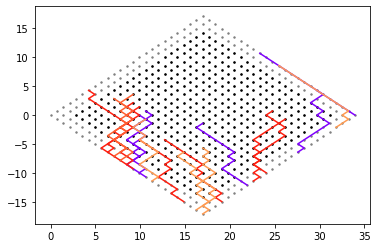

In [10]:
show(25,25,[4,5,7,2,4],15)